In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [100]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/trigger_12_03/"

# Define outut folder for plot data
plot_data_dir = f"plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1000 + 1
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True

# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"

all_TPR = {}
all_SIC = {}
all_FPR = {}
all_ROC = {}

In [101]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [102]:
SB_left = float(workflow["window_definitions"][particle_id]["SB_left"])
SR_left = float(workflow["window_definitions"][particle_id]["SR_left"])
SR_right = float(workflow["window_definitions"][particle_id]["SR_right"])
SB_right = float(workflow["window_definitions"][particle_id]["SB_right"])

print(SB_left, SB_right)

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_SS"
else:
    train_data_id = "_OS"

# train on opp sign means alt test set is samesign
if train_data_id == "_OS": 
    alt_test_data_id = "_SS"
    train_data_id_title = "_OS"
elif train_data_id == "_SS": 
    alt_test_data_id = "_OS"
    train_data_id_title = "_SS"

data_prefix = f"{project_id}_{particle_type}{train_data_id}_{jet_id}"

5.0 16.0


# Load in the original data

In [103]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [104]:
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_test_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_test_data_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_test_data_splits_2 = pickle.load(ifile)
all_test_data_splits = {**loc_all_test_data_splits_0, **loc_all_test_data_splits_1, **loc_all_test_data_splits_2}
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_scores_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_scores_splits_2 = pickle.load(ifile)
all_scores_splits = {**loc_all_scores_splits_0, **loc_all_scores_splits_1, **loc_all_scores_splits_2}
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_alt_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_alt_data_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_data_splits_2 = pickle.load(ifile)
all_alt_data_splits = {**loc_all_alt_data_splits_0, **loc_all_alt_data_splits_1, **loc_all_alt_data_splits_2}
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)


# alt scores

with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_alt_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_alt_scores_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_scores_splits_2 = pickle.load(ifile)
all_alt_scores_splits = {**loc_all_alt_scores_splits_0, **loc_all_alt_scores_splits_1, **loc_all_alt_scores_splits_2}
print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

True
True
True
True


In [105]:
print(all_test_data_splits.keys())

# Data: folds
print(all_test_data_splits[0].keys())

# Data: folds: 0
print(all_test_data_splits[0][0])


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

## Plot histograms for a small number of FPR thresholds

In [106]:
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_test_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_test_data_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_test_data_splits_2 = pickle.load(ifile)
all_test_data_splits = {**loc_all_test_data_splits_0, **loc_all_test_data_splits_1, **loc_all_test_data_splits_2}
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_scores_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_scores_splits_2 = pickle.load(ifile)
all_scores_splits = {**loc_all_scores_splits_0, **loc_all_scores_splits_1, **loc_all_scores_splits_2}
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_alt_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_alt_data_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_data_splits_2 = pickle.load(ifile)
all_alt_data_splits = {**loc_all_alt_data_splits_0, **loc_all_alt_data_splits_1, **loc_all_alt_data_splits_2}
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)


# alt scores

with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    loc_all_alt_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_1_501", "rb") as ifile:
    loc_all_alt_scores_splits_1 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_scores_splits_2 = pickle.load(ifile)
all_alt_scores_splits = {**loc_all_alt_scores_splits_0, **loc_all_alt_scores_splits_1, **loc_all_alt_scores_splits_2}
print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)



with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{working_dir}/processed_data/preprocessing_info_{particle_type}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [107]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [108]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [109]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)

    
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
        q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)

        # test_statistic(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        total_events = len(filtered_masses)




        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1874666/3307863516.py:108: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


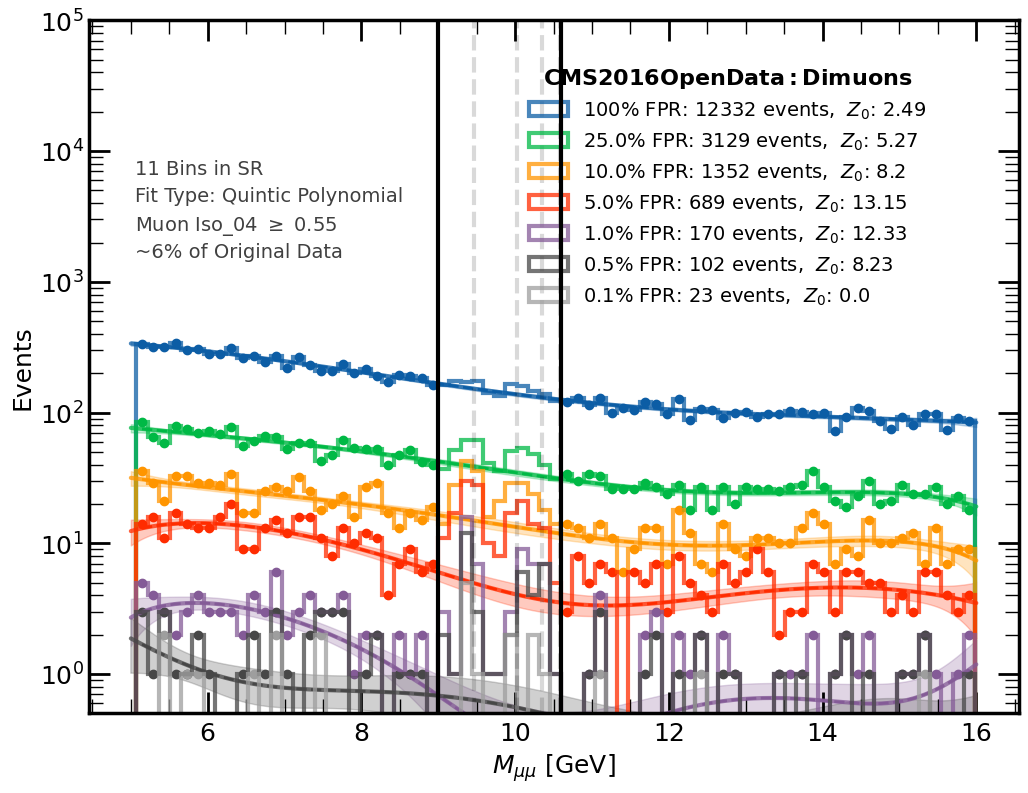

In [110]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


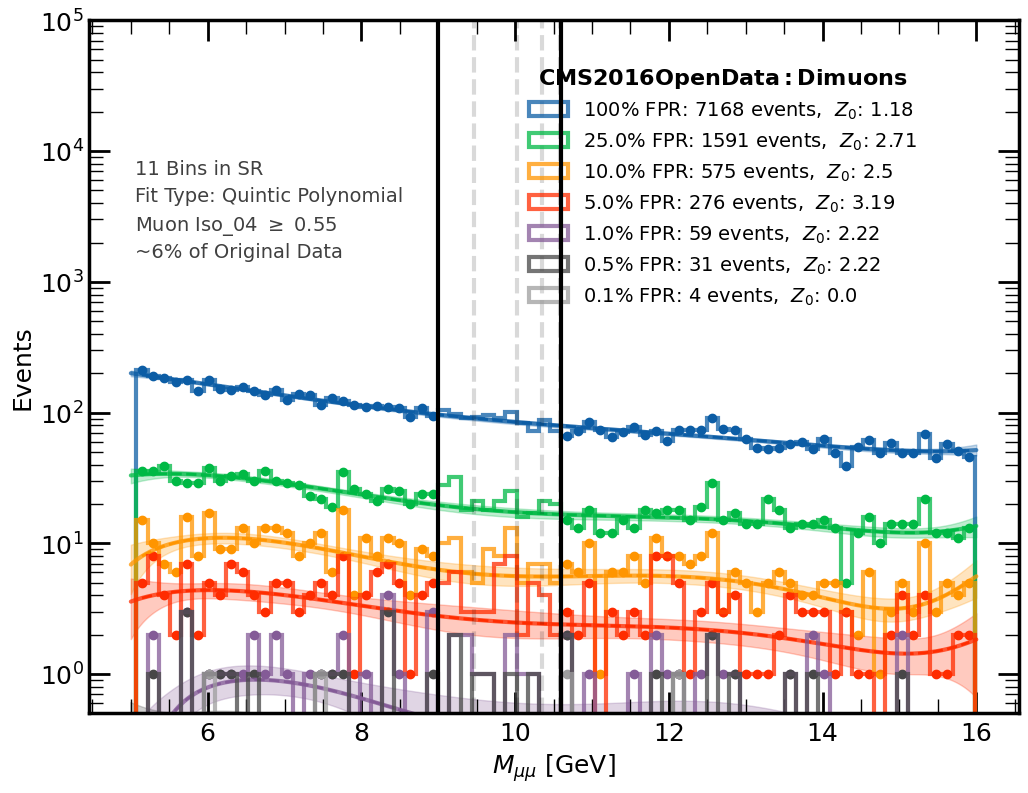

In [111]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [112]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

{'fpr_thresholds': [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001],
 'fit_type': 'quintic',
 'num_bins_SR': 12,
 'popts': [array([-4.85539405e+01,  1.38133212e+03, -3.34616024e+02,  3.18443278e+01,
         -1.36606267e+00,  2.20493972e-02]),
  array([ 1.57239759e+02,  1.95175289e+02, -4.47587864e+01,  3.52433212e+00,
         -1.06493905e-01,  7.96211404e-04]),
  array([ 9.68214859e+02, -4.04221415e+02,  7.96022901e+01, -8.01202434e+00,
          3.95692002e-01, -7.58246242e-03]),
  array([ 3.79460066e+02, -1.53990044e+02,  3.05273069e+01, -3.10167239e+00,
          1.53706705e-01, -2.93602867e-03]),
  array([ 2.43008650e+02, -1.12172538e+02,  2.13788184e+01, -2.01286418e+00,
          9.26683088e-02, -1.66628265e-03]),
  array([ 1.81730707e+02, -9.01908499e+01,  1.81825414e+01, -1.80661873e+00,
          8.76788199e-02, -1.65826722e-03]),
  array([ 1.02925706e+02, -5.10277716e+01,  1.01236859e+01, -9.92073147e-01,
          4.77860829e-02, -9.02957397e-04])],
 'pcovs': [array([[ 2.30993680e

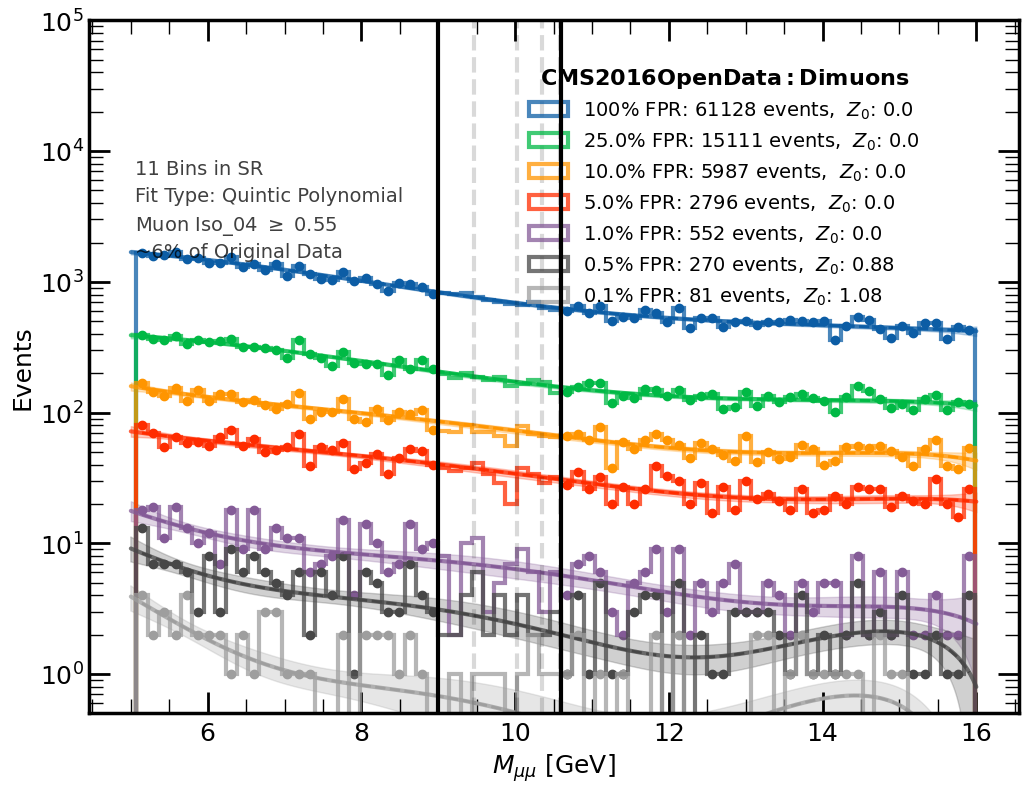

In [113]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [114]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

        
    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
                # calculate significance of bump
        if ONE_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
            q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

        label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


        hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
        # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)

    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.475
    starting_y = 0.45
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    # plt.yscale("log")
    plt.ylim(0.5, 1e3)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)

    return save_data


<>:165: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1874666/3971992411.py:165: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


dimu_pt


mu0_ip3d
mu1_ip3d


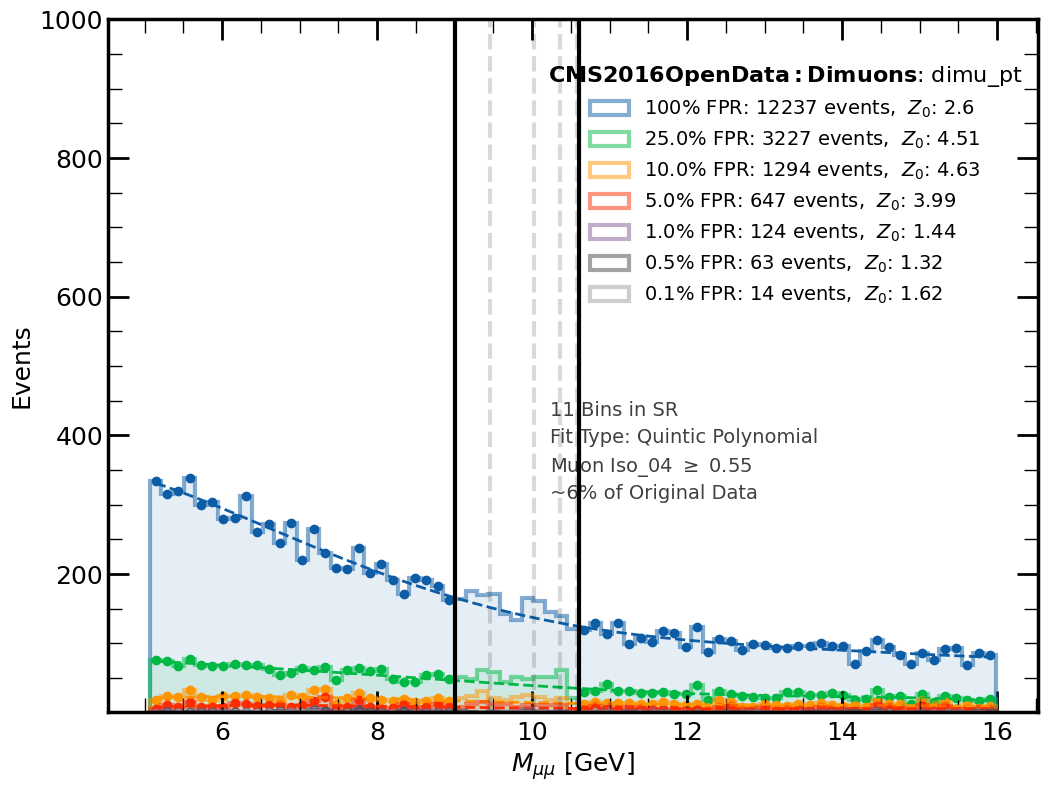

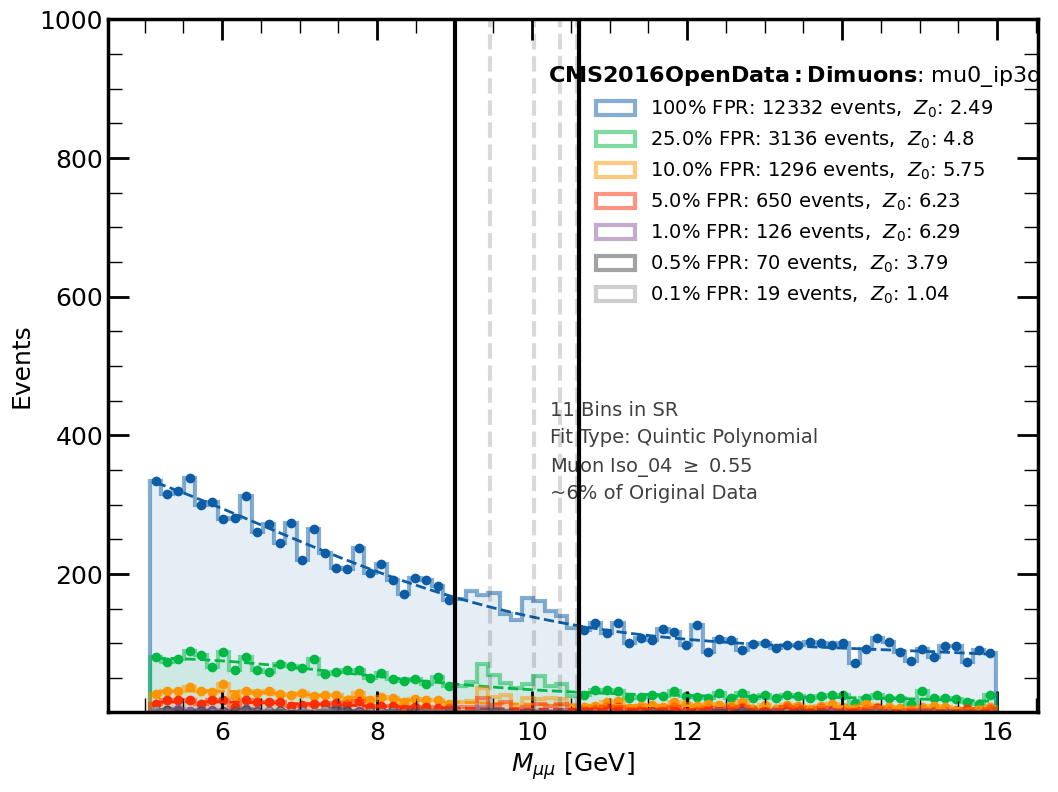

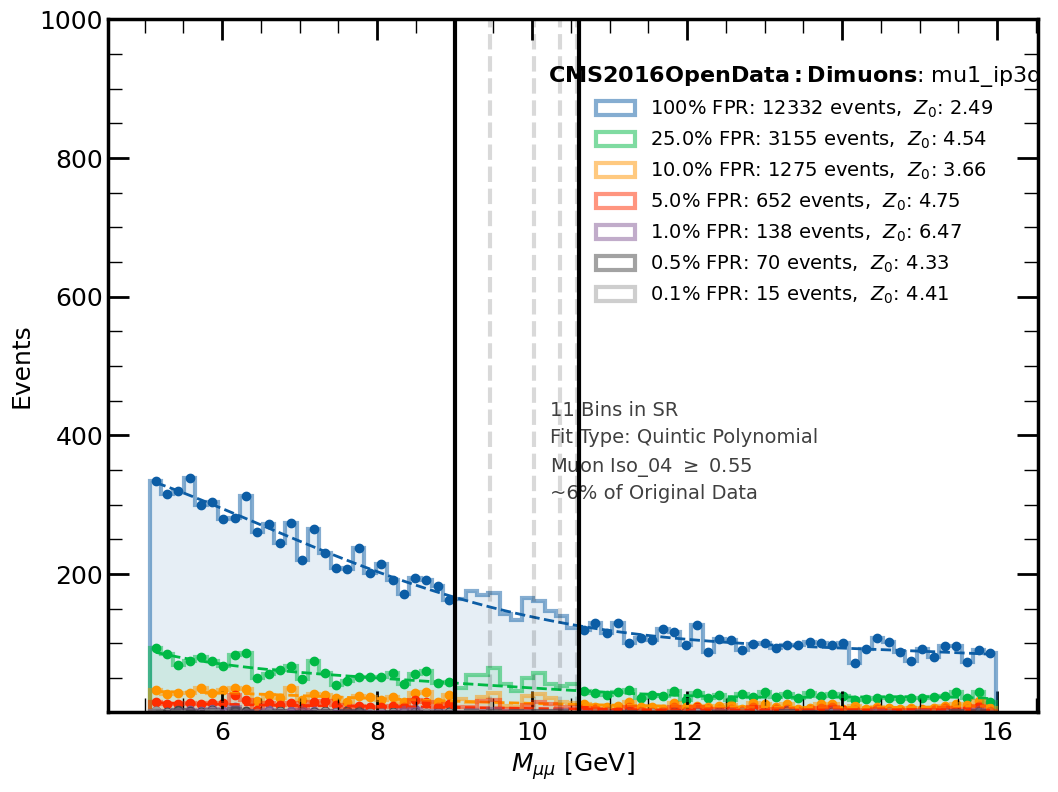

In [115]:
flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
    with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(save_data, ofile)


In [116]:


"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

            # calculate significance of bump
            if ONE_SIDED:
                q0 = calculate_test_statistic(filtered_masses_bs, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
                significance = np.sqrt(q0)

                significances[t, pseudo_e] = significance

        
    
    return significances



In [117]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]


In [118]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)

with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, score_cutoffs_finegrained)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)




On pseudo experiment 1...
On pseudo experiment 2...
On pseudo experiment 3...
On pseudo experiment 4...
On pseudo experiment 5...
On pseudo experiment 6...
On pseudo experiment 7...
On pseudo experiment 8...
On pseudo experiment 9...
On pseudo experiment 10...
On pseudo experiment 11...
On pseudo experiment 12...
On pseudo experiment 13...
On pseudo experiment 14...
On pseudo experiment 15...
On pseudo experiment 16...
On pseudo experiment 17...
On pseudo experiment 18...
On pseudo experiment 19...
On pseudo experiment 20...
On pseudo experiment 21...
On pseudo experiment 22...
On pseudo experiment 23...
On pseudo experiment 24...
On pseudo experiment 25...
On pseudo experiment 26...
On pseudo experiment 27...
On pseudo experiment 28...
On pseudo experiment 29...
On pseudo experiment 30...
On pseudo experiment 31...
On pseudo experiment 32...
On pseudo experiment 33...
On pseudo experiment 34...
On pseudo experiment 35...
On pseudo experiment 36...
On pseudo experiment 37...
On pseudo 

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_

On pseudo experiment 24...
On pseudo experiment 25...
On pseudo experiment 26...
On pseudo experiment 27...
On pseudo experiment 28...
On pseudo experiment 29...
On pseudo experiment 30...
On pseudo experiment 31...
On pseudo experiment 32...
On pseudo experiment 33...
On pseudo experiment 34...
On pseudo experiment 35...
On pseudo experiment 36...
On pseudo experiment 37...
On pseudo experiment 38...
On pseudo experiment 39...
On pseudo experiment 40...
On pseudo experiment 41...
On pseudo experiment 42...
On pseudo experiment 43...
On pseudo experiment 44...
On pseudo experiment 45...
On pseudo experiment 46...
On pseudo experiment 47...
On pseudo experiment 48...
On pseudo experiment 49...
On pseudo experiment 50...
On pseudo experiment 51...
On pseudo experiment 52...
On pseudo experiment 53...
On pseudo experiment 54...
On pseudo experiment 55...
On pseudo experiment 56...
On pseudo experiment 57...
On pseudo experiment 58...
On pseudo experiment 59...
On pseudo experiment 60...
O

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_

On pseudo experiment 268...
On pseudo experiment 269...
On pseudo experiment 270...
On pseudo experiment 271...
On pseudo experiment 272...
On pseudo experiment 273...
On pseudo experiment 274...
On pseudo experiment 275...
On pseudo experiment 276...
On pseudo experiment 277...
On pseudo experiment 278...
On pseudo experiment 279...
On pseudo experiment 280...
On pseudo experiment 281...
On pseudo experiment 282...
On pseudo experiment 283...
On pseudo experiment 284...
On pseudo experiment 285...
On pseudo experiment 286...
On pseudo experiment 287...
On pseudo experiment 288...
On pseudo experiment 289...
On pseudo experiment 290...
On pseudo experiment 291...
On pseudo experiment 292...
On pseudo experiment 293...
On pseudo experiment 294...
On pseudo experiment 295...
On pseudo experiment 296...
On pseudo experiment 297...
On pseudo experiment 298...
On pseudo experiment 299...
On pseudo experiment 300...
On pseudo experiment 301...
On pseudo experiment 302...
On pseudo experiment

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_

On pseudo experiment 468...
On pseudo experiment 469...
On pseudo experiment 470...
On pseudo experiment 471...
On pseudo experiment 472...
On pseudo experiment 473...
On pseudo experiment 474...
On pseudo experiment 475...
On pseudo experiment 476...
On pseudo experiment 477...
On pseudo experiment 478...
On pseudo experiment 479...
On pseudo experiment 480...
On pseudo experiment 481...
On pseudo experiment 482...
On pseudo experiment 483...
On pseudo experiment 484...
On pseudo experiment 485...
On pseudo experiment 486...
On pseudo experiment 487...
On pseudo experiment 488...
On pseudo experiment 489...
On pseudo experiment 490...
On pseudo experiment 491...
On pseudo experiment 492...
On pseudo experiment 493...
On pseudo experiment 494...
On pseudo experiment 495...
On pseudo experiment 496...
On pseudo experiment 497...
On pseudo experiment 498...
On pseudo experiment 499...
On pseudo experiment 500...
On pseudo experiment 501...
On pseudo experiment 502...
On pseudo experiment

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_

On pseudo experiment 711...
On pseudo experiment 712...
On pseudo experiment 713...
On pseudo experiment 714...
On pseudo experiment 715...
On pseudo experiment 716...
On pseudo experiment 717...
On pseudo experiment 718...
On pseudo experiment 719...
On pseudo experiment 720...
On pseudo experiment 721...
On pseudo experiment 722...
On pseudo experiment 723...
On pseudo experiment 724...
On pseudo experiment 725...
On pseudo experiment 726...
On pseudo experiment 727...
On pseudo experiment 728...
On pseudo experiment 729...
On pseudo experiment 730...
On pseudo experiment 731...
On pseudo experiment 732...
On pseudo experiment 733...
On pseudo experiment 734...
On pseudo experiment 735...
On pseudo experiment 736...
On pseudo experiment 737...
On pseudo experiment 738...
On pseudo experiment 739...
On pseudo experiment 740...
On pseudo experiment 741...
On pseudo experiment 742...
On pseudo experiment 743...
On pseudo experiment 744...
On pseudo experiment 745...
On pseudo experiment

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_all, SR_counts_passed/SR_counts_all
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:216: RuntimeWarning: invalid value encountered in divide
  return true_masses[pass_scores], SBL_counts_passed/SBL_counts_all, SBH_counts_passed/SBH_counts_

On pseudo experiment 852...
On pseudo experiment 853...
On pseudo experiment 854...
On pseudo experiment 855...
On pseudo experiment 856...
On pseudo experiment 857...
On pseudo experiment 858...
On pseudo experiment 859...
On pseudo experiment 860...
On pseudo experiment 861...
On pseudo experiment 862...
On pseudo experiment 863...
On pseudo experiment 864...
On pseudo experiment 865...
On pseudo experiment 866...
On pseudo experiment 867...
On pseudo experiment 868...
On pseudo experiment 869...
On pseudo experiment 870...
On pseudo experiment 871...
On pseudo experiment 872...
On pseudo experiment 873...
On pseudo experiment 874...
On pseudo experiment 875...
On pseudo experiment 876...
On pseudo experiment 877...
On pseudo experiment 878...
On pseudo experiment 879...
On pseudo experiment 880...
On pseudo experiment 881...
On pseudo experiment 882...
On pseudo experiment 883...
On pseudo experiment 884...
On pseudo experiment 885...
On pseudo experiment 886...
On pseudo experiment

In [119]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """


    


    num_experiments = num_pseudoexperiments
    fpr_thresholds = np.logspace(-4, 0, 25)[::-1]
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])


        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]


        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]


        if flip:
            feature_SBL = -feature_SBL
            feature_SR = -feature_SR
            feature_SBH = -feature_SBH

        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]

        # print(mass_SBL.shape, mass_SR.shape, mass_SBH.shape)
        # print(feature_SBL.shape, feature_SR.shape, feature_SBH.shape)

        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 1000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


        # Set up fit types
        if fit_type == "cubic": fit_function = bkg_fit_cubic
        elif fit_type == "quintic": fit_function = bkg_fit_quintic
        elif fit_type == "septic": fit_function = bkg_fit_septic


        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background
            # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            #print("chi2/dof:", chi2/n_dof)
            

            # calculate significance of bump
            if ONE_SIDED:

                q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
                significance = np.sqrt(q0)

                significances[t, e] = significance

            
    
    return significances


In [120]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [False, True, True, False] 




for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

  
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


dimu_pt


100%|██████████| 1001/1001 [15:05<00:00,  1.11it/s]


mu0_ip3d


100%|██████████| 1001/1001 [15:04<00:00,  1.11it/s]


mu1_ip3d


100%|██████████| 1001/1001 [15:05<00:00,  1.10it/s]


random


100%|██████████| 1001/1001 [16:07<00:00,  1.03it/s]


dimu_pt


100%|██████████| 1001/1001 [21:18<00:00,  1.28s/it]


mu0_ip3d


100%|██████████| 1001/1001 [21:55<00:00,  1.31s/it]


mu1_ip3d


100%|██████████| 1001/1001 [15:09<00:00,  1.10it/s]


random


100%|██████████| 1001/1001 [15:00<00:00,  1.11it/s]


In [121]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\P'
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1874666/820106902.py:34: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
/tmp/ipykernel_1874666/820106902.py:55: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 20.0)

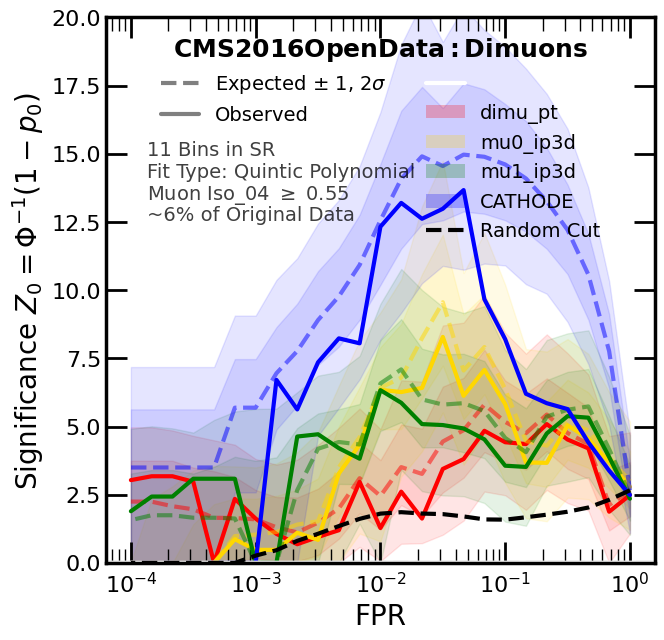

In [124]:
def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

# Artificially make a legend
plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_median, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r"~6% of Original Data"

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 20)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1874666/823049028.py:24: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
/tmp/ipykernel_1874666/823049028.py:45: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

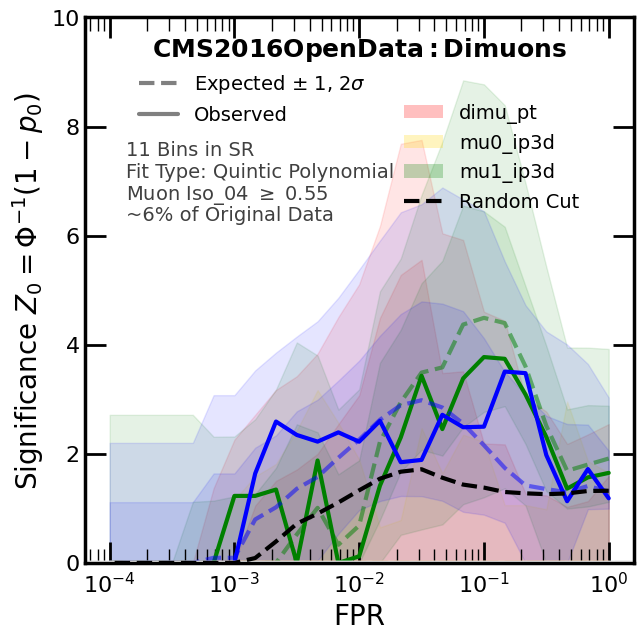

In [125]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]
    SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

# Artificially make a legend
plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_median, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r"~6% of Original Data"

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




